In [5]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def cumulative_average(numbers):
    numbers = np.array(numbers)
    cum_sum = np.cumsum(numbers)
    indices = np.arange(1, len(numbers) + 1)
    cum_avg = cum_sum / indices
    return cum_avg.tolist()

In [7]:
path = './acdm_thesis_results_no_noise_pkl/multiple_samples/'

In [11]:
files_in_ms = os.listdir(path)
files_in_ms.sort()
print(files_in_ms)

['acdm_rpf2d_20240317-191711_metrics.pkl', 'acdm_rpf2d_20240317-191957_metrics.pkl', 'acdm_rpf2d_20240317-192003_metrics.pkl', 'acdm_rpf2d_20240317-192010_metrics.pkl', 'acdm_rpf2d_20240317-203048_metrics.pkl', 'acdm_rpf2d_20240318-011929_metrics.pkl', 'acdm_rpf2d_20240318-015147_metrics.pkl', 'acdm_rpf2d_20240318-022630_metrics.pkl', 'acdm_rpf2d_20240318-023901_metrics.pkl', 'acdm_rpf2d_20240318-055342_metrics.pkl', 'acdm_rpf2d_20240318-075409_metrics.pkl', 'acdm_rpf2d_20240318-082602_metrics.pkl', 'acdm_rpf2d_20240318-093413_metrics.pkl', 'acdm_rpf2d_20240318-105943_metrics.pkl', 'acdm_rpf2d_20240318-130218_metrics.pkl', 'acdm_rpf2d_20240318-174308_metrics.pkl', 'acdm_rpf2d_20240318-232026_metrics.pkl']


In [12]:
labels = []

for filename in files_in_ms:
    parts = filename.split('_')
    labels.append(parts[-2])

In [13]:
labels

['20240317-191711',
 '20240317-191957',
 '20240317-192003',
 '20240317-192010',
 '20240317-203048',
 '20240318-011929',
 '20240318-015147',
 '20240318-022630',
 '20240318-023901',
 '20240318-055342',
 '20240318-075409',
 '20240318-082602',
 '20240318-093413',
 '20240318-105943',
 '20240318-130218',
 '20240318-174308',
 '20240318-232026']

In [14]:
metrics_list = []
for i in range(len(files_in_ms)):
    metrics_list.append(pickle.load(open(path+files_in_ms[i], 'rb')))

In [15]:
rollout_mean=[]
rollout_std=[]

    
#metrics_list is a list containing all the rollouts of each model, Each entry of the list corresponds 
#to a different model. Each entry contains a dictionary of rollouts. Each rollout contains a dictionary of metrics.
    
for metrics in metrics_list: 
    cumulative_average_of_mse = []
    
    cumulative_average_ekin = []     
    
    cumulative_average_of_sinkhorn = []
    
    #this loop is executed once per model
    for rollout in metrics.values(): #metrics.keys()=['rollout_0', 'rollout_1',...]; 
                                     #metrics.values()=[{rollout-0: ekin,mse,mse1,mse5,mse10,sinkhorn}, {rollout-1: ekin,mse,mse1,mse5,mse10,sinkhorn}, ...]
        for k, v in rollout.items(): #key 'k' contains mse1, mse5, mse10, mse20, e_kin, sinkhorn
            #determine the cumulative average of the metrics
            if k =='mse': #v has a shape of 20, cumulative average of mse also has a shape of 20
                cumulative_average_of_mse.append(cumulative_average(v))
            
            if k =='e_kin': 
                squared_errors = (v["predicted"] - v["target"])**2 
                cumulative_average_ekin.append(cumulative_average(squared_errors))
            
            if k =='sinkhorn':
                cumulative_average_of_sinkhorn.append(cumulative_average(v))

    cumulative_average_of_mse = np.array(cumulative_average_of_mse)  #shape (x,20). x is the number of rollouts and 20 is the number of time steps
    cumulative_average_ekin = np.array(cumulative_average_ekin) #(x,20)
    cumulative_average_of_sinkhorn = np.array(cumulative_average_of_sinkhorn) #(x,20)

    ## FOR MSE POSITION 
    rollout_mean_position = np.mean(cumulative_average_of_mse, axis=0) #mean across rollouts,(x, 20) --> shape (20,)
    rollout_std_position = np.std(cumulative_average_of_mse, axis=0) #std across rollouts, (x, 20) --> shape (20,)

    #### FOR EKIN
    rollout_mean_ekin = np.mean(cumulative_average_ekin, axis=0) #mean across rollouts, shape (x, 19) --> (19,)
    rollout_std_ekin = np.std(cumulative_average_ekin, axis=0) #std across rollouts shape (x, 19) --> (19,)

    #### FOR SINKHORN
    rollout_mean_sinkhorn = np.mean(cumulative_average_of_sinkhorn, axis=0) #mean across rollouts, shaoe (20,)
    rollout_std_sinkhorn = np.std(cumulative_average_of_sinkhorn, axis=0) #std across rollouts, shape (20,)

    #each entry of the lists below are for a particular model
    rollout_mean.append([rollout_mean_position,rollout_mean_ekin, rollout_mean_sinkhorn])  
    rollout_std.append([rollout_std_position, rollout_std_ekin, rollout_std_sinkhorn])


2024-04-05 10:13:22.262376: W external/xla/xla/service/gpu/nvptx_compiler.cc:703] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [16]:
#print the cumulatve average of mse , ekin and sinkhorn for each model
for i in range(len(rollout_mean)):
    print(labels[i])
    #middle index 0 is for mse, 1 is for ekin, 2 is for sinkhorn
    print(f"cumulative MSE_5 rollout mean {rollout_mean[i][0][4]:.1e}")
    print(f"cumulative MSE_5 rollout std {rollout_std[i][0][4]:.1e}")
    print(f"cumulative MSE_20 rollout mean {rollout_mean[i][0][19]:.1e}")
    print(f"cumulative MSE_20 rollout std {rollout_std[i][0][19]:.1e}")
    print(f"cumulative Ekin rollout mean {rollout_mean[i][1][18]:.1e}")
    print(f"cumulative Ekin rollout std {rollout_std[i][1][18]:.1e}")
    print(f"cumulative Sinkhorn rollout mean {rollout_mean[i][2][19]:.1e}")
    print(f"cumulative Sinkhorn rollout std {rollout_std[i][2][19]:.1e}")

    print("\n")

20240317-191711
cumulative MSE_5 rollout mean 3.3e-06
cumulative MSE_5 rollout std 2.6e-07
cumulative MSE_20 rollout mean 1.3e-04
cumulative MSE_20 rollout std 3.2e-05
cumulative Ekin rollout mean 2.0e-03
cumulative Ekin rollout std 1.2e-02
cumulative Sinkhorn rollout mean 3.4e-05
cumulative Sinkhorn rollout std 1.1e-05


20240317-191957
cumulative MSE_5 rollout mean 3.8e-06
cumulative MSE_5 rollout std 2.7e-07
cumulative MSE_20 rollout mean 1.5e-04
cumulative MSE_20 rollout std 2.4e-05
cumulative Ekin rollout mean 6.7e-04
cumulative Ekin rollout std 2.9e-03
cumulative Sinkhorn rollout mean 4.2e-05
cumulative Sinkhorn rollout std 1.1e-05


20240317-192003
cumulative MSE_5 rollout mean 1.9e-06
cumulative MSE_5 rollout std 2.7e-07
cumulative MSE_20 rollout mean 1.6e-04
cumulative MSE_20 rollout std 3.0e-05
cumulative Ekin rollout mean 3.0e-04
cumulative Ekin rollout std 5.2e-04
cumulative Sinkhorn rollout mean 2.7e-05
cumulative Sinkhorn rollout std 7.2e-06


20240317-192010
cumulative M

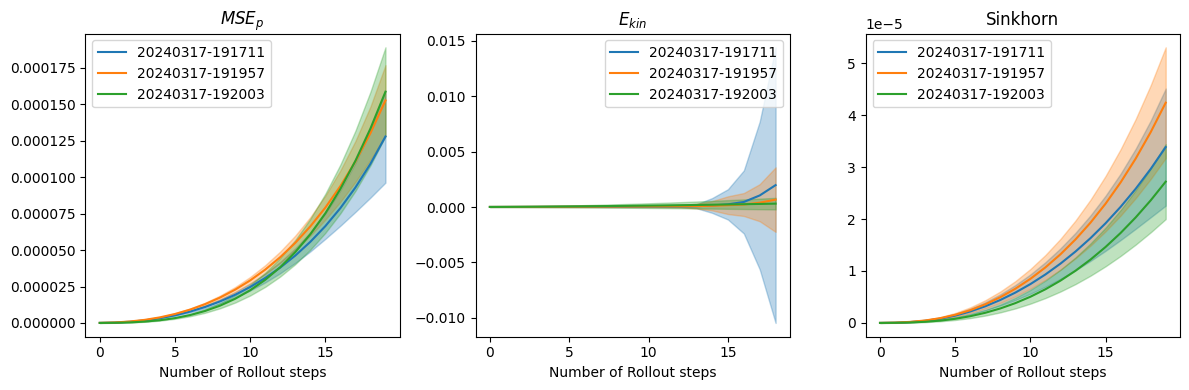

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for j in range(3):# runs as many times as the number of files /models
    for i,m in enumerate(['$MSE_p$', '$E_{kin}$', 'Sinkhorn']): 
        ax[i].plot(np.arange(len(rollout_mean[j][i])),rollout_mean[j][i], label=labels[j], color=plt.cm.tab10.colors[j])        
        ax[i].fill_between(np.arange(len(rollout_mean[j][i])),y1=rollout_mean[j][i] - rollout_std[j][i], 
                        y2=rollout_mean[j][i] + rollout_std[j][i], 
                        alpha=0.3,label="", color=plt.cm.tab10.colors[j])
        ax[i].set_title(m)
        ax[i].set_xlabel('Number of Rollout steps')
        ax[i].legend()
        fig.tight_layout()